<h3>Look out for comments starting with`#` in the cells
and some comments in Markdown between the cells</h3>

In [231]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [232]:
df = pd.read_csv('car_price.csv')

In [233]:
len(df)

11914

In [234]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


<h3>As we see there're inconsistencies in the headers: a) some with `_`, others with spaces b) various capitalization.
=> we need to normalize them</h3>

In [235]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
# will replace spaces for _ and lower everything

df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [236]:
# above we deal with columns and here we deal with data itself
# to remove inconsistencies from it
temp_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in temp_columns:
    df[col] = df[col].str.lower().str.replace(" ", "_")

<AxesSubplot:xlabel='msrp', ylabel='Count'>

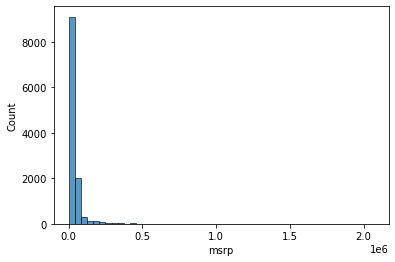

In [237]:
# y is our target variable (msrp - manufacturer’s suggested retail price) which we want to predict. 
# One of the first steps of data analysis is visualization of target variable to see the distribution.
sns.histplot(df.msrp, bins=50)
# we see that we have long tail (to the right) => lots of cars with cheap price on the left side

<AxesSubplot:xlabel='msrp', ylabel='Count'>

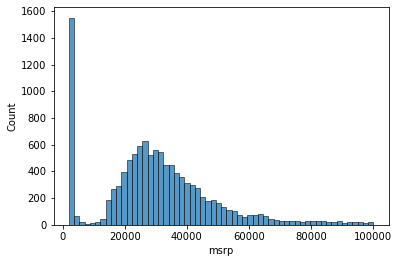

In [238]:
sns.histplot(df.msrp[df.msrp < 100000])

<AxesSubplot:xlabel='msrp', ylabel='Count'>

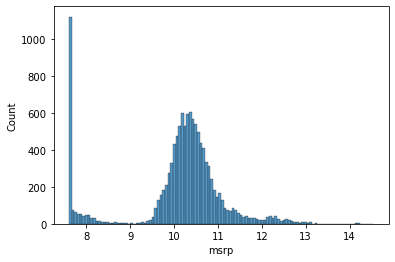

In [239]:
# to deal with long tail we apply logarithm on it. *otherwise a) difficult to see distribution
# b) model won't learn well enough log(variable + 1) where + 1 will prevent log 0 if there're
# such cases. But numpy encompasses it
log_msrp = np.log1p(df.msrp)
sns.histplot(log_msrp)

In [240]:
# check for missing values
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

In [241]:
# remember that we get log of price and we need to `re-apply` it

In [242]:
df.isnull().sum()/len(df) * 100
# roughly 31% is missing in market_category. We'll deal with it later

make                  0.000000
model                 0.000000
year                  0.000000
engine_fuel_type      0.025180
engine_hp             0.579151
engine_cylinders      0.251805
transmission_type     0.000000
driven_wheels         0.000000
number_of_doors       0.050361
market_category      31.408427
vehicle_size          0.000000
vehicle_style         0.000000
highway_mpg           0.000000
city_mpg              0.000000
popularity            0.000000
msrp                  0.000000
dtype: float64

# Validation framework

In [243]:
# now we'll split dataset in 3 parts: training/validation/testing
length = len(df)
test_chunk = int(length * 0.2)
valid_chunk = int(length * 0.2)
train_chunk = length - (test_chunk + valid_chunk)

np.random.seed(2)
# to make the code be random, but reproducible we use `seed`
idx = np.arange(length)
np.random.shuffle(idx)
# to make indicies go not in 0, 1, 45.., but 55, 4, 100 etc
df_mixed = df.iloc[idx]

df_train = df_mixed.iloc[:train_chunk].copy()
df_valid = df_mixed.iloc[train_chunk:train_chunk + valid_chunk].copy()
df_test = df_mixed.iloc[train_chunk + valid_chunk:].copy()
len(df_train), len(df_valid), len(df_test)

(7150, 2382, 2382)

In [244]:
# here we apply log to remove tail and hence create target variables
# also we implement `values` to get not pd.Series, but np.ndarray (values themselves)
y_test = np.log1p(df_test.msrp.values)
y_valid = np.log1p(df_valid.msrp.values)
y_train = np.log1p(df_train.msrp.values)

In [245]:
# to eradicate accidental use of our target variable, we remove it from train dataset
del df_test['msrp']
del df_train['msrp']
del df_valid['msrp']

In [209]:
df_test.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
11195,gmc,vandura,1994,regular_unleaded,165.0,6.0,automatic,rear_wheel_drive,3.0,NaN,compact,cargo_van,20,15,549
673,mercedes-benz,600-class,1993,regular_unleaded,389.0,12.0,automatic,rear_wheel_drive,2.0,luxury,large,coupe,15,11,617
11270,toyota,venza,2013,regular_unleaded,268.0,6.0,automatic,all_wheel_drive,4.0,"crossover,performance",midsize,wagon,25,18,2031
752,volvo,740,1992,regular_unleaded,114.0,4.0,automatic,rear_wheel_drive,4.0,luxury,midsize,sedan,26,18,870
3137,ford,crown_victoria,2010,flex-fuel_(unleaded/e85),224.0,8.0,automatic,rear_wheel_drive,4.0,flex_fuel,large,sedan,24,16,5657


# Below is step by step explanation
# of how to do regression. Final one will
# be after current chunk

In [218]:
# y = g(X) where g() is a model, X is a matrix dataset
# (X is a matrix where the columns of rows are `features` of observations), y is predicted value
# Ex: xi is a one row of observation with multiple features like make/model/year etc.
# Let's look at makeshift example. `w` is weight, they're what our model learns when we train it
w0 = 7.17
w = [0.01, 0.04, 0.002]
n = 3

def linear_regression(xi):
    result = w0
    for i in range(n):
        result += xi[i] * w[i]
    return np.expm1(result)
    # as we took log of the price, we need to undo it now by using exp(x + 1)

# g(xi) = w0 + w1 * xi1 + w2 * xi2 + w3 * xi3
xi = [453, 11, 86]
# xi is a vector with n components
# w is a vector with n components as well
linear_regression(xi)

# w0 is baseline - what we'll get if don't know anything (or everything will be 0)
# `wi` will adjust price by adding this `wi`. But as we have `xi * wi`, result of xi1 * w1: 453 horses * 0.01 = 4.53
# I.e each additional horse power adds 0.01 to the price. We have 453 and it results in 4.53 addition

222347.2221101062

In [219]:
# not fixed on 3 (as we use len())
w = [0.01, 0.04, 0.002]
xi = [453, 11, 86]
w0 = 7.17

def dot(xi, w):
    n = len(w)
    res = 0.0
    for i in range(n):
        res += xi[i] * w[i]
    return np.expm1(res)

def linear_regression(xi):
    return w0 + dot(xi, w)

linear_regression(xi)

177.22754151723709

In [220]:
# combining w0 & w + adding dummy 1 to xi
w0 = 7.17
w = [w0] + [0.01, 0.04, 0.002]
xi = [453, 11, 86]


def dot(xi, w):
    n = len(w)
    res = 0.0
    for i in range(n):
        res += xi[i] * w[i]
    return res

def linear_regression(xi, w):
    xi = [1] + xi
    return dot(xi, w)

linear_regression(xi, w)

12.312

In [221]:
# X - matrix, xi is 0, 1, 2 of the matrix
# and xi1/xi2/xi3 represent features (prcie/mpg etc)
X = [[1, 148, 24, 1385],
     [1, 132, 25, 2031],
     [1, 453, 11, 86]]

w0 = 7.17
w = [w0] + [0.01, 0.04, 0.003]

predictions = []
 
for xi in X:
    pred = dot(xi, w)
    # dot() from above
    predictions.append(pred)

predictions

[13.765, 15.583, 12.398]

In [222]:
# X - matrix, xi is 0, 1, 2 of the matrix
# and xi1/xi2/xi3 represent features (prcie/mpg etc)
X = [[1, 148, 24, 1385],
     [1, 132, 25, 2031],
     [1, 453, 11, 86]]

w0 = 7.17
w = [w0] + [0.01, 0.04, 0.003]

predictions = []

X = np.array(X)
predictions = X.dot(w)
predictions

array([13.765, 15.583, 12.398])

# End of explanation chunk

In [94]:
# .shape[0] is rows dimension
# .shape[1] is columns dimensio
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    # it's for prepending matrix
    # with 1 as we did above
    X = np.column_stack([ones, X])
    
    # normal equation
    # a: transpose & mult
    XTX = X.T.dot(X)
    # inverse of matrix
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    # split into bias (w0) and w 
    return w[0], w[1:]

# Baseline solution

In [95]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg',
        'city_mpg', 'popularity']

In [155]:
def prepare_X(df):
    df_num = df[base]
    # remember missing values? Now we deal with them.
    # 2 most popular approaches: fill with 0 or replace with avg().
    # here we stick. with first
    # + if recall linear regression formula, xi * wi. xi will be
    # 0 and hence this variable won't have impact on the result
    df_num = df_num.fillna(0)
    # next step is to convert df to np.array()
    # we can do it with either np.array() or .values
    X = df_num.values
    return X

In [162]:
# above we trained the model
# and now we apply it to the training dataset
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train.dot(w)
y_pred

array([ 9.54792783,  9.38733977,  9.67197758, ..., 10.30423015,
       11.9778914 ,  9.99863111])

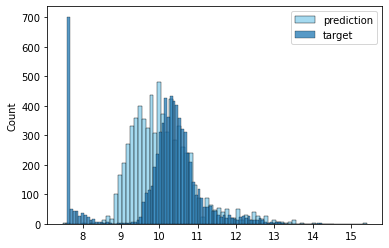

In [147]:
# to observe `quality` of predictions, we use histplot.
sns.histplot(y_pred, label='prediction', color = "skyblue")
sns.histplot(y_train, label='target')
plt.legend()
# prediction power of the model isn't good enough
# as we see difference

In [179]:
# but looking at plots all the time isn't the best option.
# Using special metrics is an option.
# RMSE (root mean squared error) is the most common
def rmse(y, y_pred):
    # diff. between predicted and actual values + sum()
    # PS: we don't have sum() as we do `elementwise` operation
    # PS2: for each element of y_pred, we subtract the corresponding element of y
    error = y_pred - y
    # squared and `/m`
    mse = (error ** 2).mean()
    # root. is taken
    return np.sqrt(mse)

# comparing to another models' result can
# tell us what is better.
# The lower the rmse the better
# because the model’s predictions are off by `result of rmse`

In [149]:
rmse(y_train, y_pred)

0.7554192603920132

In [150]:
# apply model on the validation dataset.
# i.e. we use `w0 & w` after having trained
# it on the train dataset and now use them
# to see how model behaves with dataset
# it has never seen before
X_val = prepare_X(df_valid)
y_pred = w0 + X_val.dot(w)
y_pred

array([ 9.86288014, 10.37013608,  9.69868129, ..., 10.4916625 ,
        9.57091361, 10.40022147])

In [151]:
rmse(y_valid, y_pred)

0.7616530991301601

In [103]:
# feature engineering - process of adding/removing features.
# Aim - improved rmse calculated on the validation data
df_train.year.max()

2017

# Feature engineering

In [104]:
# let's update `prepare_X` function
# 1. as we modify dataframe (`side effect`) then we'd
# better create copy() of our dataset
# 2 base.copy() is done for the same reason
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    # let's add `age` column. It'll be an elementwise operation
    # where we find diff. between max()_year and every other element
    df['age'] = 2017 - df.year
    features.append('age')
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [180]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train.dot(w)
print('training:', rmse(y_train, y_pred))

X_validation = prepare_X(df_valid)
y_pred = w0 + X_validation.dot(w)
print('validation:', rmse(y_valid, y_pred))

(7150,) train
(7150,) predictions
training: 0.5058876515487503
(2382,) train
(2382,) predictions
validation: 0.5076038849557034


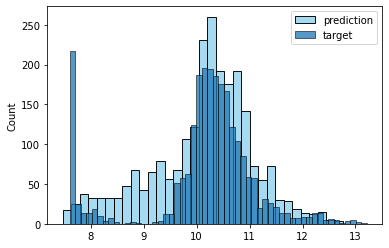

In [106]:
# as we can see from histogram  as well, result has imrpoved
sns.histplot(y_pred, label='prediction', color = "skyblue")
sns.histplot(y_valid, label='target')
plt.legend()

In [109]:
# take 5 most common makes
df['make'].value_counts().head(5)

chevrolet     1123
ford           881
volkswagen     809
toyota         746
dodge          626
Name: make, dtype: int64

In [167]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    for i in [2, 3, 4]:
        feature = 'num_doors_%s' %i
        df[feature] = (df['number_of_doors'] == i).astype(int)
        features.append(feature)

    for j in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' %j
        df[feature] = (df['make'] == j).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

# ! We train model and get w0 & w then
# apply on validation dataset. But we don't
# train and don't get w0 & w from it

In [210]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train.dot(w)
print('training:', rmse(y_train, y_pred))

X_valid = prepare_X(df_valid)
y_pred = w0 + X_valid.dot(w)
print('validation:', rmse(y_valid, y_pred))

training: 0.5058876515487503
validation: 0.5076038849557034


In [211]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)

    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [212]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train.dot(w)
print('training:', rmse(y_train, y_pred))

X_valid = prepare_X(df_valid)
y_pred = w0 + X_valid.dot(w)
print('validation:', rmse(y_valid, y_pred))

training: 0.4745380510924004
validation: 0.4685879194659198


In [213]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)

    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']:
        feature = 'is_driven_wheens_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)

    for v in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']:
        feature = 'is_mc_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    for v in ['compact', 'midsize', 'large']:
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)

    for v in ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']:
        feature = 'is_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [214]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train.dot(w)
print('training:', rmse(y_train, y_pred))

X_valid = prepare_X(df_valid)
y_pred = w0 + X_valid.dot(w)
print('validation:', rmse(y_valid, y_pred))

training: 1607.4898641126447
validation: 830.8920785817741


# Below one is dedicated to regularization

In [215]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg',
        'city_mpg', 'popularity']

In [216]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]
# r is alf. The more r we add the smaller weights become

In [217]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df['age'] = 2017 - df.year
    features.append('age')
    
    # inside loop 3 pd.Series will be created
    for i in [2, 3, 4]:
        feature = 'num_doors_%s' %i
        # astype() converts. 0 to False and 1 to True
        value = (df['number_of_doors'] == i).astype(int)
        df[feature] = value
        features.append(feature)
    
    for j in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make%s' %j
        df[feature] = (df['make'] == j).astype(int)
        features.append(feature)
    
    for i in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        
        feature = 'is_type_%s' %i
        df[feature] = (df['engine_fuel_type'] == i).astype(int)
        features.append(feature)
    
    for i in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' %i
        df[feature] = (df['transmission_type'] == i).astype(int)
        features.append(feature)
    
    for j in ['front_wheel_drive', 'rear_wheel_drive',
              'all_wheel_drive', 'four_wheel_drive']:
        
        feature = 'is_driven_wheels_%s' %j
        df[feature] = (df['driven_wheels'] == j).astype(int)
        features.append(feature)
    
    for i in ['crossover', 'flex_fuel', 'luxury', 
              'luxury,performance', 'hatchback']:
        
        feature = 'is_mc_%s' %i
        df[feature] = (df['market_category'] == i).astype(int)
        features.append(feature)
    
    for j in ['compact', 'midsize', 'large']:
        
        feature = 'is_size_%s' %j
        df[feature] = (df['vehicle_size'] == j).astype(int)
        features.append(feature)
    
    for i in ['sedan', '4dr_suv', 'coupe', 'convertible',
              '4dr_hatchback']:
        
        feature = 'is_style_%s' %i
        df[feature] = (df['vehicle_style'] == i).astype(int)
        features.append(feature)
    
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    
    return X

In [218]:
X_train = prepare_X(df_train) 

In [219]:
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print('%5s, %.2f, %.2f, %.2f' % (r, w0, w[10], w[25]))

    0, -694700695602717184.00, 217.87, 164.75
0.001, 7.19, 0.20, -0.07
 0.01, 7.18, 0.20, -0.07
  0.1, 7.05, 0.20, -0.07
    1, 6.22, 0.20, -0.06
   10, 4.39, 0.16, -0.04


In [220]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

X_val = prepare_X(df_valid)
y_pred = w0 + X_val.dot(w)
print('validation:', rmse(y_valid, y_pred))
# 1. removal of feature may help
# 2. add regularization
# 3. do both

validation: 0.460226762660452


In [221]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_valid)

for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w0 + X_val.dot(w)
    print('%6s' %r, rmse(y_valid, y_pred))

 1e-06 0.4602255729396709
0.0001 0.46022549453464073
 0.001 0.460226762660452
  0.01 0.4602394963262388
   0.1 0.4603700695813603
     1 0.46182980426538967
     5 0.4684079627533807
    10 0.47572481006935274


In [222]:
# finally test againt test dataset
# check if difference between validation and testing
# dataset isn't too big
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_valid)
y_pred = w0 + X_val.dot(w)
print('validation:', rmse(y_valid, y_pred))

X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

validation: 0.4602394963262388
test: 0.45718136796926057


# Using the model

In [181]:
i = 7
data = df.iloc[i].to_dict()
data

{'make': 'bmw',
 'model': '1_series',
 'year': 2012,
 'engine_fuel_type': 'premium_unleaded_(required)',
 'engine_hp': 300.0,
 'engine_cylinders': 6.0,
 'transmission_type': 'manual',
 'driven_wheels': 'rear_wheel_drive',
 'number_of_doors': 2.0,
 'market_category': 'luxury,high-performance',
 'vehicle_size': 'compact',
 'vehicle_style': 'coupe',
 'highway_mpg': 28,
 'city_mpg': 20,
 'popularity': 3916,
 'msrp': 39300}

In [182]:
X_test = prepare_X(df[data])[0]
y_pred = w0 + X_test.dot(w)
# as we received log of the price,
# we need to undo it
suggestion = np.expm1(y_pred)
suggestion

37263.23197344916